In [31]:
# Coinbase Sandbox Demo - Backtesting
#
# this demo uses the Coinbase Pro client for Python: 
# https://github.com/danpaquin/coinbasepro-python
#
# it's recommended to run cbpro in its own Python environment:
# conda create --name environment_name
#
# pip install cbpro
# or
# pip install git+git://github.com/danpaquin/coinbasepro-python.git
#
# there are a number of libraries that need to be in the python environment for this demo
# to run.  please review the import statements below and install the necessary dependencies
# before running this notebook.

import os

import cbpro

import json, hmac, hashlib, time, requests, base64
from requests.auth import AuthBase

import time
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt

In [33]:
# get list of products

import cbpro

import json, hmac, hashlib, time, requests, base64
from requests.auth import AuthBase

# Define Public Client
public_client = cbpro.PublicClient()

# Get Products
products = pd.DataFrame(public_client.get_products())

products.sort_values('max_market_funds')

print(products[:10])

products.to_csv('products.csv')

         id base_currency quote_currency base_min_size    base_max_size  \
0  LINK-BTC          LINK            BTC    0.10000000    6500.00000000   
1  BAND-EUR          BAND            EUR    0.10000000   18000.00000000   
2   EOS-BTC           EOS            BTC    0.10000000   50000.00000000   
3   ETH-DAI           ETH            DAI    0.01000000     700.00000000   
4   ETC-USD           ETC            USD    0.10000000   20000.00000000   
5  COMP-USD          COMP            USD    0.01000000    1700.00000000   
6  WBTC-BTC          WBTC            BTC    0.00010000      10.00000000   
7   OMG-GBP           OMG            GBP    1.00000000  150000.00000000   
8   XLM-EUR           XLM            EUR    1.00000000  600000.00000000   
9   FIL-EUR           FIL            EUR    0.01000000    3400.00000000   

  quote_increment base_increment display_name min_market_funds  \
0      0.00000001     0.01000000     LINK/BTC           0.0001   
1      0.00010000     0.01000000     BAND/

In [19]:
# Get Historic Rates
# the max number of data points for a single request is 300 candles
# if start/end time and granularity results in more than 300 data points,
# the request will be rejected.
# Make multiple requests if fine granularity results in > 300 data points.

import cbpro

# Define Public Client
public_client = cbpro.PublicClient()

# Define ticker symbol to retrieve
symbol = 'BTC-USD'

# Issue: start and end dates results in error
# Default returns 300 data points at specified granularity
# Optional parameters: start and end dates need to be in ISO 8601 format (YYYYMMDD)
#start = 20201215
#end = 20201231

# granularity is the time between ticks and must be one of these values:
# {60, 300, 900, 3600, 21600, 86400} which corresponds to
# one minute (60 sec), five minutes (300 sec), fifteen minutes (900 sec),
# one hour (3600 sec), six hours (21600 sec), and one day (86400 sec)

granularity = 3600

try:
    tick_data = pd.DataFrame(public_client.get_product_historic_rates(symbol, granularity=granularity))
except: print("Request is invalid: verify start-end dates and granularity results in less than 300 data points")

tick_data.rename(columns={0:'time', 1:'low', 2:'high', 3:'open', 4:'close', 5:'volume'}, inplace=True)

tick_data.to_csv('BTC-USD.csv')

In [66]:
# work with saved historic data to minimize the number of api requests

import pandas as pd

tick_data = pd.read_csv('BTC-USD.csv', index_col=0, infer_datetime_format=True, parse_dates=True)

tick_data.iloc[:, 0] = pd.to_datetime(tick_data.iloc[:, 0], infer_datetime_format=True, unit='s')

tick_data.set_index('time', inplace=True)

tick_data.sort_values(by='time', inplace=True)

tick_data.head

<bound method NDFrame.head of                           low      high      open     close       volume
time                                                                    
2020-12-19 05:00:00  22941.15  23102.57  23069.62  22989.49   442.723675
2020-12-19 06:00:00  22869.69  23040.56  22989.49  22891.89   433.894350
2020-12-19 07:00:00  22840.70  23068.45  22890.53  22882.83   435.238026
2020-12-19 08:00:00  22770.00  23013.09  22882.83  23008.26   541.138616
2020-12-19 09:00:00  22957.60  23062.05  23008.27  22997.35   406.833304
...                       ...       ...       ...       ...          ...
2020-12-31 12:00:00  28450.00  29010.70  28923.33  28674.91  1100.140290
2020-12-31 13:00:00  28000.00  28671.28  28664.27  28573.44  2136.043425
2020-12-31 14:00:00  28028.37  28573.96  28573.44  28390.10  1436.865092
2020-12-31 15:00:00  28389.95  28868.35  28390.10  28820.86  1420.898793
2020-12-31 16:00:00  28580.00  28854.99  28820.87  28712.59   303.167196

[300 rows x 5 column

In [70]:
# select a subset of the data for analysis

import pandas as pd

sub = tick_data.iloc[:148]

sub.head

<bound method NDFrame.head of                           low      high      open     close      volume
time                                                                   
2020-12-19 05:00:00  22941.15  23102.57  23069.62  22989.49  442.723675
2020-12-19 06:00:00  22869.69  23040.56  22989.49  22891.89  433.894350
2020-12-19 07:00:00  22840.70  23068.45  22890.53  22882.83  435.238026
2020-12-19 08:00:00  22770.00  23013.09  22882.83  23008.26  541.138616
2020-12-19 09:00:00  22957.60  23062.05  23008.27  22997.35  406.833304
...                       ...       ...       ...       ...         ...
2020-12-25 04:00:00  23438.00  23599.53  23463.93  23596.38  230.125793
2020-12-25 05:00:00  23523.88  23634.55  23595.16  23593.01  190.584739
2020-12-25 06:00:00  23541.28  23669.85  23593.00  23617.70  182.336056
2020-12-25 07:00:00  23509.94  23669.92  23617.13  23639.13  710.792784
2020-12-25 08:00:00  23592.12  23867.81  23642.95  23670.44  515.643141

[148 rows x 5 columns]>

<ipython-input-75-b4b9c021c902>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['Mid'] = sub.loc[:, ('open','close')].mean(axis=1)
<ipython-input-75-b4b9c021c902>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['SMA'] = sub.loc[:, 'Mid'].rolling(i).mean().shift(i)


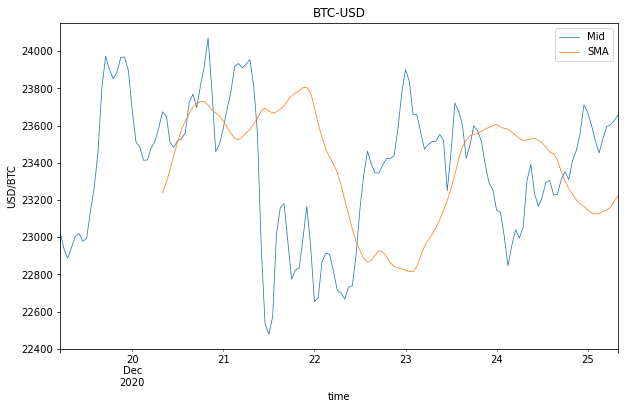

In [75]:
# analyze data sub-set

import time
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt

i = 14 # Number of ticks to use for simple moving average (SMA)

sub['Mid'] = sub.loc[:, ('open','close')].mean(axis=1)
sub['SMA'] = sub.loc[:, 'Mid'].rolling(i).mean().shift(i)
sub[['Mid', 'SMA']].plot(figsize=(10,6), lw=0.75, title='BTC-USD', ylabel='USD/BTC')
plt.savefig('1-BTC-USD_SMA.png')
plt.show()


In [81]:
# backtesting example - SMA trading strategy

import pandas as pd

# Load data for backtesting

tick_data = pd.read_csv('BTC-USD.csv', index_col=0, infer_datetime_format=True, parse_dates=True)

tick_data.iloc[:, 0] = pd.to_datetime(tick_data.iloc[:, 0], infer_datetime_format=True, unit='s')

tick_data.set_index('time', inplace=True)

tick_data.sort_values(by='time', inplace=True)

data = pd.DataFrame(tick_data['close']).dropna()

data.rename(columns={'close':'BTC-USD'}, inplace=True)

data.head

<bound method NDFrame.head of                       BTC-USD
time                         
2020-12-19 05:00:00  22989.49
2020-12-19 06:00:00  22891.89
2020-12-19 07:00:00  22882.83
2020-12-19 08:00:00  23008.26
2020-12-19 09:00:00  22997.35
...                       ...
2020-12-31 12:00:00  28674.91
2020-12-31 13:00:00  28573.44
2020-12-31 14:00:00  28390.10
2020-12-31 15:00:00  28820.86
2020-12-31 16:00:00  28712.59

[300 rows x 1 columns]>

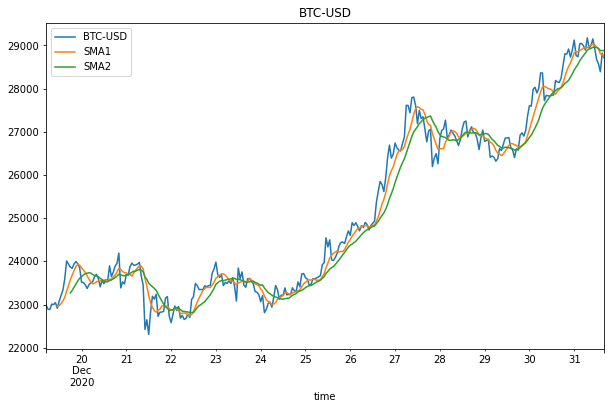

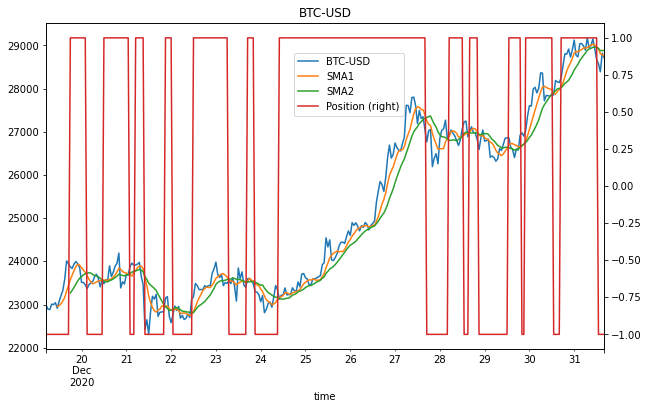

In [99]:
# backtesting example - SMA trading strategy

import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt

%matplotlib inline

SMA1 = 7
SMA2 = 14

data['SMA1'] = data.iloc[:,0].rolling(SMA1).mean()
data['SMA2'] = data.iloc[:,0].rolling(SMA2).mean()

data.iloc[:,0:3].plot(figsize=(10,6), title='BTC-USD')
plt.savefig('2-BTC-USD_SMA_Strat.png')
plt.show()

'''
SMA Trading Strategy:

Go long (= +1) when the shorter SMA is above the longer SMA
Go short (= -1) when the shorter SMA is below the longer SMA
'''

data['Position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)

data.tail()

ax = data.plot(secondary_y='Position', figsize=(10,6), title='BTC-USD')
ax.get_legend().set_bbox_to_anchor((0.65, 0.7))
plt.savefig('3-BTC-USD_SMA_Position.png')
plt.show()

In [101]:
# backtesting example - SMA trading strategy

# This example is adapted from Python For Finance, 2nd ed., Hilpisch, Yves.
# Chapter 15 Trading Strategies, Vectorized Backtesting

import numpy as np
import pandas as pd

# Calculate log returns
data['Returns'] = np.log(data['BTC-USD']/data['BTC-USD'].shift(1))

data['Strategy'] = data['Position'].shift(1)*data['Returns']

data.round(4).head()

,BTC-USD,SMA1,SMA2,Position,Returns,Strategy
time,,,,,,
2020-12-19 05:00:00,22989.49,NaN,NaN,-1,NaN,NaN
2020-12-19 06:00:00,22891.89,NaN,NaN,-1,-0.0043,0.0043
2020-12-19 07:00:00,22882.83,NaN,NaN,-1,-0.0004,0.0004
2020-12-19 08:00:00,23008.26,NaN,NaN,-1,0.0055,-0.0055
2020-12-19 09:00:00,22997.35,NaN,NaN,-1,-0.0005,0.0005


In [104]:
# backtesting example - SMA trading strategy

# This example is adapted from Python For Finance, 2nd ed., Hilpisch, Yves.
# Chapter 15 Trading Strategies, Vectorized Backtesting

import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt

%matplotlib inline

data.dropna(inplace=True)

# Returns comparison: hold long or use SMA strategy
np.exp(data[['Returns', 'Strategy']].sum())

Returns     1.199487
Strategy    1.027011
dtype: float64

In [105]:
# Volatility comparison: hold long or use SMA strategy
data[['Returns', 'Strategy']].std()*252**0.5

Returns     0.140443
Strategy    0.140796
dtype: float64

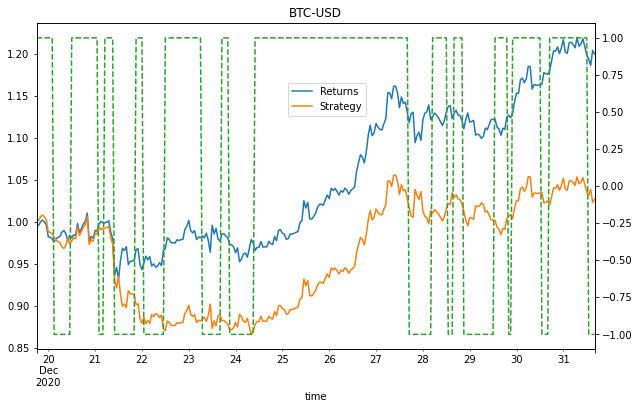

In [109]:
ax = data[['Returns', 'Strategy']].cumsum().apply(np.exp).plot(figsize=(10,6), title='BTC-USD')
data['Position'].plot(ax=ax, secondary_y='Position', style='--')
ax.get_legend().set_bbox_to_anchor((0.6, 0.7))
plt.savefig('4-BTC-USD_LongVsSMA.png')
plt.show()

In [111]:
# Optimizing the SMA trading strategy

# This example is adapted from Python For Finance, 2nd ed., Hilpisch, Yves.
# Chapter 15 Trading Strategies, Vectorized Backtesting

# A brute force method is used in an attempt to optimize SMA1 and SMA2 values.
# SMA1 = 7, SMA2 = 14

# ** THIS TAKES ABOUT 30 - 60 SEC TO RUN **

from itertools import product
import numpy as np
import pandas as pd

# Load data for brute force optimization

symbol = 'BTC-USD'

tick_data = pd.read_csv(symbol+'.csv', index_col=0, infer_datetime_format=True, parse_dates=True)
tick_data.iloc[:, 0] = pd.to_datetime(tick_data.iloc[:, 0], infer_datetime_format=True, unit='s')
tick_data.set_index('time', inplace=True)
tick_data.sort_values(by='time', inplace=True)
raw = pd.DataFrame(tick_data['close']).dropna()
raw.rename(columns={'close':symbol}, inplace=True)
raw.head

# Brute force optimization
# range(min, max, increment size)
sma1 = range(2, 40, 2)
sma2 = range(14, 250, 4)

results = pd.DataFrame()

for SMA1, SMA2 in product(sma1, sma2):
    data = pd.DataFrame(raw[symbol])
    data.dropna(inplace = True)
    data['Returns'] = np.log(data[symbol]/data[symbol].shift(1))
    data['SMA1'] = data[symbol].rolling(SMA1).mean()
    data['SMA2'] = data[symbol].rolling(SMA2).mean()
    data.dropna(inplace = True)
    data['Position'] = np.where(data['SMA1']>data['SMA2'], 1, -1)
    data['Strategy'] = data['Position'].shift(1)*data['Returns']
    data.dropna(inplace = True)
    perf = np.exp(data[['Returns', 'Strategy']].sum())
    results = results.append(pd.DataFrame(
                {'SMA1':SMA1, 'SMA2': SMA2,
                'MARKET': perf['Returns'],
                'STRATEGY': perf['Strategy'],
                'OUT': perf['Strategy']-perf['Returns']},
                index=[0]), ignore_index=True)

results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1121 entries, 0 to 1120
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SMA1      1121 non-null   int64  
 1   SMA2      1121 non-null   int64  
 2   MARKET    1121 non-null   float64
 3   STRATEGY  1121 non-null   float64
 4   OUT       1121 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 43.9 KB


In [112]:
results.sort_values('OUT', ascending=False).head(7)

,SMA1,SMA2,MARKET,STRATEGY,OUT
296,12,18,1.199209,1.308491,0.109282
295,12,14,1.203034,1.257241,0.054208
786,28,90,1.210293,1.243369,0.033076
963,34,90,1.210293,1.238756,0.028463
562,20,138,1.211253,1.236060,0.024806
964,34,94,1.215244,1.239043,0.023799
905,32,94,1.215244,1.233709,0.018465


In [1]:
# Linear OLS Regression

# This example applies linear OLS regression to predict the direction of the instrument's movement.

# Adapted from Python For Finance, 2nd ed., Hilpisch, Yves.
# Chapter 15 Trading Strategies, Vectorized Backtesting

import numpy as np
import pandas as pd

# Load data for OLS Regression

symbol = 'BTC-USD'

tick_data = pd.read_csv(symbol+'.csv', index_col=0, infer_datetime_format=True, parse_dates=True)
tick_data.iloc[:, 0] = pd.to_datetime(tick_data.iloc[:, 0], infer_datetime_format=True, unit='s')
tick_data.set_index('time', inplace=True)
tick_data.sort_values(by='time', inplace=True)
raw = pd.DataFrame(tick_data['close']).dropna()
raw.rename(columns={'close':symbol}, inplace=True)

data = pd.DataFrame(raw[symbol])

data['returns'] = np.log(data/data.shift(1))

data.dropna(inplace=True)

data['direction'] = np.sign(data['returns']).astype(int)

data.head()

,BTC-USD,returns,direction
time,,,
2020-12-19 06:00:00,22891.89,-0.004254,-1
2020-12-19 07:00:00,22882.83,-0.000396,-1
2020-12-19 08:00:00,23008.26,0.005466,1
2020-12-19 09:00:00,22997.35,-0.000474,-1
2020-12-19 10:00:00,23043.16,0.001990,1


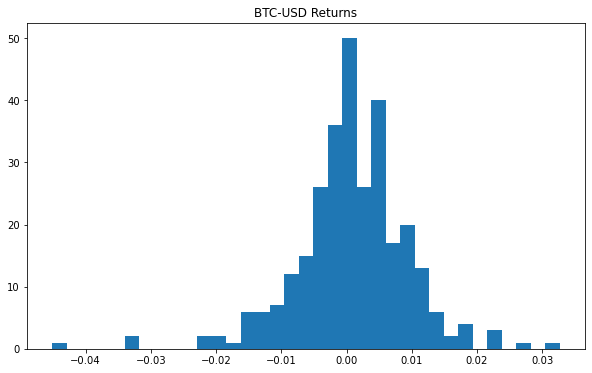

In [116]:
# Plot a histogram of returns
plt.figure(figsize=(10,6))
plt.hist(data['returns'], bins=35)
plt.title('BTC-USD Returns')
plt.savefig('5-BTC-USD_Hist.png')
plt.show()

In [2]:
# Create the features data by lagging the log returns and visualize it in combination with the 
# returns data

# Adapted from Python For Finance, 2nd ed., Hilpisch, Yves.
# Chapter 15 Trading Strategies, Vectorized Backtesting

lags = 2

def create_lags(data):
    global cols
    cols = []
    for lag in range(1, lags + 1):
        col = 'lag_{}'.format(lag)
        data[col] = data['returns'].shift(lag)
        cols.append(col)

create_lags(data)

data.head()

,BTC-USD,returns,direction,lag_1,lag_2
time,,,,,
2020-12-19 06:00:00,22891.89,-0.004254,-1,NaN,NaN
2020-12-19 07:00:00,22882.83,-0.000396,-1,-0.004254,NaN
2020-12-19 08:00:00,23008.26,0.005466,1,-0.000396,-0.004254
2020-12-19 09:00:00,22997.35,-0.000474,-1,0.005466,-0.000396
2020-12-19 10:00:00,23043.16,0.001990,1,-0.000474,0.005466


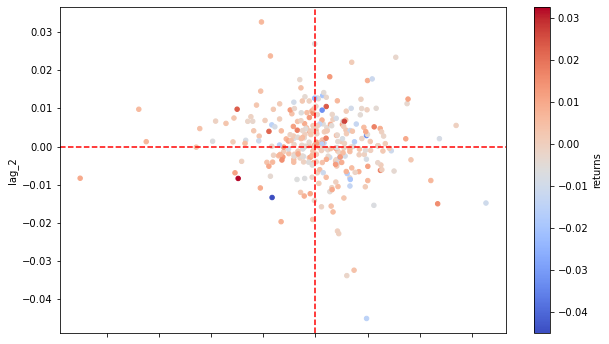

In [121]:
import numpy as np
import pandas as pd
from pylab import mpl, plt

%matplotlib inline

data.dropna(inplace=True)

data.plot.scatter(x='lag_1', y='lag_2', c='returns', cmap='coolwarm', figsize=(10,6), colorbar=True)
plt.axvline(0, c='r', ls='--')
plt.axhline(0, c='r', ls='--')
plt.savefig('6-BTC-USD_Lag_Rtns_Scatter.png')
plt.show()

In [4]:
# Perform linear OLS regression on dataset

from sklearn.linear_model import LinearRegression

model = LinearRegression()

data.dropna(inplace=True)

data['pos_ols_1'] = model.fit(data[cols], data['returns']).predict(data[cols])

data['pos_ols_2'] = model.fit(data[cols], data['direction']).predict(data[cols])

data[['pos_ols_1', 'pos_ols_2']].head()

,pos_ols_1,pos_ols_2
time,,
2020-12-19 08:00:00,0.000879,0.147212
2020-12-19 09:00:00,0.000190,0.040962
2020-12-19 10:00:00,0.000941,0.113981
2020-12-19 11:00:00,0.000611,0.096134
2020-12-19 12:00:00,0.001545,0.207417


In [5]:
# transform real values into directional values

data[['pos_ols_1', 'pos_ols_2']] = np.where(data[['pos_ols_1', 'pos_ols_2']] > 0, 1, -1)

data['pos_ols_1'].value_counts()

 1    239
-1     58
Name: pos_ols_1, dtype: int64

In [6]:
data['pos_ols_2'].value_counts()

 1    247
-1     50
Name: pos_ols_2, dtype: int64

In [7]:
(data['pos_ols_1'].diff()!=0).sum()

96

In [9]:
(data['pos_ols_2'].diff()!=0).sum()

76

In [10]:
# Compare OLS strategies
# OLS_1: OLS based on lagged returns
# OLS_2: OLS based on direction

import numpy as np

data['strat_ols_1'] = data['pos_ols_1']*data['returns']

data['strat_ols_2'] = data['pos_ols_2']*data['returns']

data[['returns', 'strat_ols_1', 'strat_ols_2']].sum().apply(np.exp)

returns        1.254766
strat_ols_1    1.322613
strat_ols_2    1.229719
dtype: float64

In [11]:
# The number of correct and false predictions for each strategy

(data['direction']==data['pos_ols_1']).value_counts()

True     169
False    128
dtype: int64

In [17]:
print('OLS_1: Returns')
169/(169+128)

OLS_1: Returns


0.569023569023569

In [12]:
(data['direction']==data['pos_ols_2']).value_counts()

True     165
False    132
dtype: int64

In [16]:
print('OLS_2: Directional')
165/(165+132)

OLS_2: Directional


0.5555555555555556

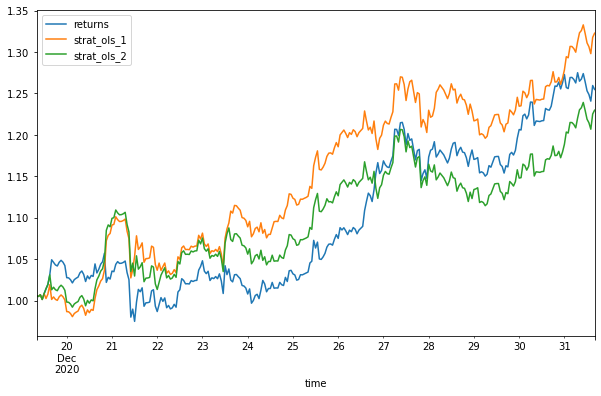

In [19]:
import numpy as np
import pandas as pd
from pylab import mpl, plt

%matplotlib inline

data[['returns', 'strat_ols_1', 'strat_ols_2']].cumsum().apply(np.exp).plot(figsize=(10,6))
plt.savefig('7-BTC-USD_OLS_ReturnsVsDirection.png')
plt.show()

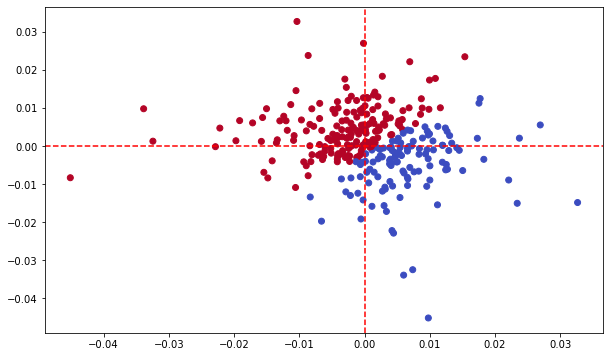

In [22]:
# Perform k-means clustering on dataset

from sklearn.cluster import KMeans

model = KMeans(n_clusters=2, random_state=0) # use 2 clusters

model.fit(data[cols])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300, n_clusters=2, n_init=10, n_jobs=None,\
      precompute_distances='auto', random_state=0, tol=0.0001, verbose=0)

data['pos_clus'] = model.predict(data[cols])

# based upon cluster values, choose a position (long: 1, or short: -1)
data['pos_clus'] = np.where(data['pos_clus'] == 1, -1, 1)

plt.figure(figsize=(10,6))
plt.scatter(data[cols].iloc[:,0], data[cols].iloc[:,1], c=data['pos_clus'], cmap='coolwarm')
plt.axvline(0, c='r', ls='--')
plt.axhline(0, c='r', ls='--')
plt.savefig('8-BTC-USD_K-Means_Clustering.png')
plt.show()

In [23]:
# K-Means Returns vs. Benchmark

data['strat_clus'] = data['pos_clus']*data['returns']

data[['returns', 'strat_clus']].sum().apply(np.exp)

returns       1.254766
strat_clus    1.396107
dtype: float64

In [24]:
# K-Means Hit Ratio
(data['direction'] == data['pos_clus']).value_counts()

True     164
False    133
dtype: int64

In [25]:
164/(164+133)

0.5521885521885522

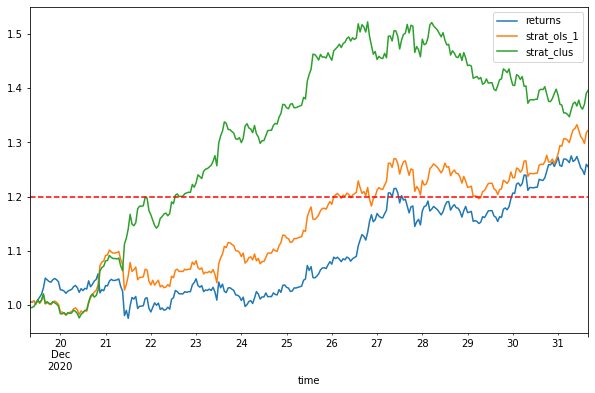

In [30]:
data[['returns', 'strat_ols_1', 'strat_clus']].cumsum().apply(np.exp).plot(figsize=(10,6))
plt.axhline(1.2, c='r', ls='--')
plt.savefig('9-BTC-USD_K-Means_ClusteringVsBenchmark.png')
plt.show()